In [1]:
## Phase 1: Initial Data Inspection (The Basics)

# --- Step 1: Loading the data ---

import pandas as pd
import numpy as np
from itertools import combinations
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt


Inter_sales_rp = pd.read_csv(r'c:\Users\obasi\Downloads\International sale Report.csv', encoding= 'latin1' )

# --- Step 2: Getting the Dimensions ---
print(f'The dataset has {Inter_sales_rp.shape[0]} rows and {Inter_sales_rp.shape[1]} columns')

# --- Step 3: Inspecting the Data Types and Missing Values ---
print(Inter_sales_rp.info())

The dataset has 37432 rows and 10 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37432 entries, 0 to 37431
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   index      37432 non-null  int64 
 1   DATE       37431 non-null  object
 2   Months     37407 non-null  object
 3   CUSTOMER   36392 non-null  object
 4   Style      36392 non-null  object
 5   SKU        34958 non-null  object
 6   Size       36392 non-null  object
 7   PCS        36392 non-null  object
 8   RATE       36392 non-null  object
 9   GROSS AMT  36392 non-null  object
dtypes: int64(1), object(9)
memory usage: 2.9+ MB
None


In [2]:
Inter_sales_rp.describe()

,index
count,37432.000000
mean,18715.500000
std,10805.831975
min,0.000000
25%,9357.750000
50%,18715.500000
75%,28073.250000
max,37431.000000


In [3]:
## Phase 2: Targeted Data Cleaning

# --- Step 2.1: Drop Redundant and Useless rows ---

  # Drop the redundant 'index' columns
try:
    Inter_sales_rp = Inter_sales_rp.drop('index', axis=1)
except KeyError:
    pass

  # Drop rows where key columns are nulls. We can use the 'style' column as a proxy
     # since 6 different columns are null for the same 1040 rows.
Inter_sales_rp.dropna(subset=['Style'], inplace=True)

# --- Step 2.2: Robust Numerical Conversion ---

numerical_cols = ['PCS', 'RATE', 'GROSS AMT']

for col in numerical_cols:
    # Use pd.to_numeric with errors='coerce' to turn bad strings (like 'RATE') into NaN
    Inter_sales_rp[col] = pd.to_numeric(Inter_sales_rp[col], errors='coerce')
    """ 
    The errors='coerce' parameter tells Panda: "Try to convert the value to a value
    to a number. If you fail, don't crash the code; instead, change the problematic value
    into NaN ( Not a Number).
    """ 

print("\n --- Mininum Value Check --- \n")
print("Minimum PCS:", Inter_sales_rp['PCS'].min())
print("Minimum Rate:", Inter_sales_rp['RATE'].min())
print("Minimum GROSS AMT:", Inter_sales_rp['GROSS AMT'].min())

# --- Step 2.3: Date Type Conversion ---

  # convert the 'DATE' column to datetime format
    # Pandas is usually smart, but specifying the format ('%m-%d-%y) is better
Inter_sales_rp['DATE'] = pd.to_datetime(Inter_sales_rp['DATE'], format='%m-%d-%y', errors='coerce')

# --- Step 2.4: Feature engineering - Create new columns for Month and Year

Inter_sales_rp['Transaction_Month'] = Inter_sales_rp['DATE'].dt.month
Inter_sales_rp['Transaction_Year'] = Inter_sales_rp['DATE'].dt.year

# --- Step 2.5: Drop the redundant 'Months' ---
try: 
    Inter_sales_rp = Inter_sales_rp.drop('Months', axis=1)
except KeyError:
    pass

  # List of columns to standardize
text_cols = ['CUSTOMER', 'Style', 'SKU', 'Size']

# --- Step 2.6: Standarding Text ---

 # lists of column to standardize
for col in text_cols:
    # Convert to string (to handle any potential non-string object types gracefully)
    # Convert to lowercase
    # Strip leading/trailing whitespace
    Inter_sales_rp[col] = Inter_sales_rp[col].astype(str).str.lower().str.strip()

print("--- Data Structure After Date Cleaning & Feature Creation ---")
print(Inter_sales_rp.head())
print("\n--- Check Data Types Again ---")
print(Inter_sales_rp.dtypes)

Inter_sales_rp_cleaned = Inter_sales_rp.copy()
Inter_sales_rp_cleaned.to_csv("cleaned_sales_data.csv", index=False)



 --- Mininum Value Check --- 

Minimum PCS: 1.0
Minimum Rate: 100.0
Minimum GROSS AMT: 0.0
--- Data Structure After Date Cleaning & Feature Creation ---
        DATE            CUSTOMER    Style             SKU Size  PCS    RATE  \
0 2021-06-05  revathy loganathan  men5004    men5004-kr-l    l  1.0  616.56   
1 2021-06-05  revathy loganathan  men5004   men5004-kr-xl   xl  1.0  616.56   
2 2021-06-05  revathy loganathan  men5004  men5004-kr-xxl  xxl  1.0  616.56   
3 2021-06-05  revathy loganathan  men5009    men5009-kr-l    l  1.0  616.56   
4 2021-06-05  revathy loganathan  men5011    men5011-kr-l    l  1.0  616.56   

   GROSS AMT  Transaction_Month  Transaction_Year  
0      617.0                6.0            2021.0  
1      617.0                6.0            2021.0  
2      617.0                6.0            2021.0  
3      617.0                6.0            2021.0  
4      617.0                6.0            2021.0  

--- Check Data Types Again ---
DATE                 dateti

In [4]:
## Phase 3: Feature Engineering - Part 1

Inter_sales_rp_feature = Inter_sales_rp.copy()

# --- Step 3.1: Handling the SKU Null Values ---
 
  # Create a Series containing non-null SKU values
non_null_skus = Inter_sales_rp_feature.dropna(subset=['SKU'])
 
  # Group by Style and Size, and find the mode ( the most frequent SKU)
    # If a (Style, Size) pair only maps to one SKU, this will be the unique SKU.
sku_mapping = non_null_skus.groupby(['Style', 'Size'])['SKU'].agg(lambda x: x.mode().iloc[0] 
                                                                  if not x.mode().empty 
                                                                  else None).reset_index()

  # Convvert the result to a dictionary for faster lookup
sku_dict = sku_mapping.set_index(['Style', 'Size'])['SKU'].to_dict()

# --- Step 3.2: Apply imputations ---

  # Fill missing SKU values
def impute_sku(row):
    # Only try to fill if the SKU is NaN
    if pd.isna(row['SKU']):
        # look up the corresponding SKU using the Style and Size from the mapping dictionary
        key = (row['Style'], row['Size'])

        if key in sku_dict:
            # If a mapping is found, mark it as ambiguous/unknown
            return f"{row['Style']}_SKU_AMBIGUOUS"
        return row['SKU'] # Keep the original SKU if it was not NaN
    
  # Apply the function to the Dataframe
Inter_sales_rp_feature['SKU'] = Inter_sales_rp_feature.apply(impute_sku, axis=1)

  # Report the success
print(f"SKU NaNs remaining after imputation: {Inter_sales_rp_feature['SKU'].isnull().sum()}")

SKU NaNs remaining after imputation: 36392


In [5]:
## Phase 4: Feature Engineering - Part 2 (Analytical Features)

# --- Step 4.1: Revenue and Return Flags ---

  # Net Revenue (The actual money from the transaction)
"""
This is a critical feature for the 'Revenue Drivers' and 
'Profitability Index' questions.
"""
Inter_sales_rp_feature['Net_Revenue'] = Inter_sales_rp_feature['PCS'] * Inter_sales_rp_feature['RATE']

  # Is Return Flag (essential for seperating sales from returns)
"""
Since minimum PCS was 1.0, we will assume this data does not explicitly contain returns
represented by negative PCS values. However, we'll create the column defensively.
"""
Inter_sales_rp_feature['Is_Return'] = (Inter_sales_rp_feature['PCS'] < 0).astype(int)

  # Sales Velocity Measure (Transaction Size)
    # Although we have PCS, sometimes categorizing transaction size is helpful for EDA

  # We calculate the bins first, then apply labels based on how many unique bins exist
bins = pd.qcut(Inter_sales_rp_feature['PCS'], q=3, duplicates='drop')
n_bins = len(bins.cat.categories)

  # Only apply as many labels as there are bins
labels = ['Small', 'Medium', 'Large'][:n_bins]
Inter_sales_rp_feature['Sale_volume_category'] = pd.qcut(
    Inter_sales_rp_feature['PCS'], 
    q=3, 
    labels=labels, 
    duplicates='drop'
)

  # Price Segment Categorization
    # Calculate the unique bin edges first
price_bins = pd.qcut(Inter_sales_rp_feature['RATE'], q=4, duplicates='drop')

  # Check how many unique categories actually survived
n_unique_bins = len(price_bins.cat.categories)

  # Create a matching list of labels
price_labels = ['Low', 'Mid-Low', 'Mid-High', 'High'][:n_unique_bins]

  # Apply qcut again with the correct number of labels
Inter_sales_rp_feature['Price_Segment'] = pd.qcut(
    Inter_sales_rp_feature['RATE'], 
    q=4, 
    labels=price_labels, 
    duplicates='drop'
)
print("\n--- Final Feature Set Preview (head and dtypes) ---")
print(Inter_sales_rp_feature.head())
print(Inter_sales_rp_feature.dtypes)

Inter_sales_rp_feature.to_csv(
    "feature_engineered_sales_data.csv",
    index=False
)


--- Final Feature Set Preview (head and dtypes) ---
        DATE            CUSTOMER    Style   SKU Size  PCS    RATE  GROSS AMT  \
0 2021-06-05  revathy loganathan  men5004  None    l  1.0  616.56      617.0   
1 2021-06-05  revathy loganathan  men5004  None   xl  1.0  616.56      617.0   
2 2021-06-05  revathy loganathan  men5004  None  xxl  1.0  616.56      617.0   
3 2021-06-05  revathy loganathan  men5009  None    l  1.0  616.56      617.0   
4 2021-06-05  revathy loganathan  men5011  None    l  1.0  616.56      617.0   

   Transaction_Month  Transaction_Year  Net_Revenue  Is_Return  \
0                6.0            2021.0       616.56          0   
1                6.0            2021.0       616.56          0   
2                6.0            2021.0       616.56          0   
3                6.0            2021.0       616.56          0   
4                6.0            2021.0       616.56          0   

  Sale_volume_category Price_Segment  
0                Small       M

In [6]:
## Phase 5: EDA

# ----  Sales & Financial Performance ----

  # 1. Revenue Drivers

print("\n--- Running Pareto Analysis on Styles ---\n")
total_revenue = Inter_sales_rp_feature['Net_Revenue'].sum()

# Group by Style and calculate total revenue per style
style_revenue = Inter_sales_rp_feature.groupby('Style')['Net_Revenue'].sum().reset_index()
style_revenue = style_revenue.sort_values(by='Net_Revenue', ascending=False)

# Calculate cumulative revenue and percentage
style_revenue['Cumulative_Revenue'] = style_revenue['Net_Revenue'].cumsum()
style_revenue['Cumulative_Percent'] = (style_revenue['Cumulative_Revenue'] / total_revenue ) * 100

# Identify the 80% cutoff point
eighty_percent_cutoff = style_revenue[style_revenue['Cumulative_Percent'] <= 80]
num_styles_for_80_percent = eighty_percent_cutoff.shape[0]

# Save the analysis result to a CSV file
style_revenue.to_csv('Style_Pareto_Analysis.csv', index=False)

print(f"\nTotal Number of Unique Styles: {Inter_sales_rp_feature['Style'].nunique()}")
print(f"Number of Styles accounting for the top 80% of revenue: {num_styles_for_80_percent}")
print("Style Pareto Analysis saved to: Style_Pareto_Analysis.csv")



   # 2. Profitability Index (Styles)

print("\n--- Profitability Index Analysis (Top 10 Styles) ---")

profit_index = Inter_sales_rp_feature.groupby('Style').agg(
    Avg_Rate=('RATE', 'mean'),             # Average Price per unit
    Avg_Gross_Amt=('GROSS AMT', 'mean'),   # Average Transaction Value
    Total_PCS=('PCS', 'sum')
).reset_index()

# Top 10 by Average RATE (Premium Products)
top_rate = profit_index.sort_values(by='Avg_Rate', ascending=False).head(10)
print("\nTop 10 Styles by Average Unit Rate (Premium Products):")
print(top_rate[['Style', 'Avg_Rate', 'Avg_Gross_Amt']].round(2))

# Top 10 by Average GROSS AMT (High Basket Value Transactions)
top_gross_amt = profit_index.sort_values(by='Avg_Gross_Amt', ascending=False).head(10)
print("\nTop 10 Styles by Average Transaction Value:")
print(top_gross_amt[['Style', 'Avg_Rate', 'Avg_Gross_Amt']].round(2))

# Add category labels
top_rate['Category'] = 'Top by Avg Rate'
top_gross_amt['Category'] = 'Top by Avg Gross Amount'

# Combine both tables
profitability_index = pd.concat(
    [top_rate, top_gross_amt],
    ignore_index=True
)

# Save to CSV
profitability_index.to_csv('Profitability_Index.csv', index=False)

print("Profitability_Index.csv saved successfully.")



   # 3. Seasonal Trend Analysis 

print("\n--- Running Seasonal Trend Analysis ---")

# Group by Year and Month and calculate total GROSS AMT
monthly_sales = Inter_sales_rp_feature.groupby(['Transaction_Year', 'Transaction_Month'])['GROSS AMT'].sum().reset_index()

# Create a clean date for sorting and plotting
# Use string concatenation and conversion for a standard YYYY-MM format
monthly_sales['Year_Month'] = monthly_sales['Transaction_Year'].astype(int).astype(str) + '-' + \
                              monthly_sales['Transaction_Month'].astype(int).astype(str).str.zfill(2)

# Sort the results chronologically
monthly_sales = monthly_sales.sort_values('Year_Month')

# Save the result to a CSV file for detailed analysis
monthly_sales.to_csv('Monthly_Sales_Trend.csv', index=False)

print("Monthly Sales Trend Analysis saved to: Monthly_Sales_Trend.csv")
print("\nFirst 5 rows of the Monthly Sales Trend:")
print(monthly_sales.head())



# 4. Sales Velocity
print("\n--- Sales Velocity Analysis (Top 10 SKUs) ---")

# Identify Top 10 Best-Selling SKUs by total PCS
top_10_skus_list = Inter_sales_rp_feature.groupby('SKU')['PCS'].sum().nlargest(10).index.tolist()

# Calculate the duration of the data in months
min_date = Inter_sales_rp_feature['DATE'].min()
max_date = Inter_sales_rp_feature['DATE'].max()
# Calculate difference in months: use the floor of the difference (e.g., 2021-06 to 2022-03 is 10 months)
total_months = (max_date.year - min_date.year) * 12 + (max_date.month - min_date.month) + 1

# Calculate the total PCS sold for these top 10 SKUs
top_10_sales = Inter_sales_rp_feature[Inter_sales_rp_feature['SKU'].isin(top_10_skus_list)].groupby('SKU')['PCS'].sum().reset_index()
top_10_sales = top_10_sales.rename(columns={'PCS': 'Total_PCS'})

# Calculate Average Monthly Sales Volume
top_10_sales['Avg_Monthly_PCS'] = top_10_sales['Total_PCS'] / total_months
top_10_sales = top_10_sales.sort_values(by='Avg_Monthly_PCS', ascending=False)
top_10_sales.to_csv('Sales_Velocity.csv', index=False)
print(f"Data period covers approximately {total_months} months ({min_date.strftime('%Y-%m')} to {max_date.strftime('%Y-%m')}).")
print("\nTop 10 SKUs by Average Monthly Sales Volume (PCS):")
print(top_10_sales[['SKU', 'Total_PCS', 'Avg_Monthly_PCS']].round(2))


--- Running Pareto Analysis on Styles ---


Total Number of Unique Styles: 1043
Number of Styles accounting for the top 80% of revenue: 45
Style Pareto Analysis saved to: Style_Pareto_Analysis.csv

--- Profitability Index Analysis (Top 10 Styles) ---

Top 10 Styles by Average Unit Rate (Premium Products):
                 Style  Avg_Rate  Avg_Gross_Amt
1038  shipping charges   6755.00           0.00
1037          shipping   5521.49           0.00
1041              tags   5183.33           0.00
1042      tags(labour)   4955.00           0.00
818             sar086   2798.38        1846.50
817             sar079   2798.38        1846.50
98               j0057   2292.88        1960.75
327            jan8641   2248.00        4215.00
245              j0277   2191.33        1420.52
236              j0245   2088.93        1739.32

Top 10 Styles by Average Transaction Value:
       Style  Avg_Rate  Avg_Gross_Amt
325  jan8622    1949.0         9745.0
323  jan8612    1799.0         8995.0
328  

In [7]:
# --- Customer and Market Analysis ---



# 1. Top Tier Customers & Product Profile 

print("\n--- Top Tier Customers Analysis ---")

# Identify Top 10 Customers by Revenue
customer_revenue = Inter_sales_rp_feature.groupby('CUSTOMER')['Net_Revenue'].sum().reset_index()
top_10_customers = customer_revenue.sort_values(by='Net_Revenue', ascending=False).head(10)
top_10_names = top_10_customers['CUSTOMER'].tolist()

print(f"\nTop 10 Customers by Net Revenue:\n{top_10_customers.round(2)}")

# Analyze Product Profile of Top 10
top_10_transactions = Inter_sales_rp_feature[Inter_sales_rp_feature['CUSTOMER'].isin(top_10_names)]

# Find the most frequent Style and Size among these transactions (The Mode)
most_frequent_style = top_10_transactions['Style'].mode().iloc[0] if not top_10_transactions['Style'].mode().empty else "N/A"
most_frequent_size = top_10_transactions['Size'].mode().iloc[0] if not top_10_transactions['Size'].mode().empty else "N/A"
print(f"\nProduct Profile of Top 10 Customers:")
print(f"Most Frequent Style: {most_frequent_style}")
print(f"Most Frequent Size: {most_frequent_size}")



# 2.  Customer Concentration 

print("\n--- Customer Concentration Analysis ---")

total_revenue = Inter_sales_rp_feature['Net_Revenue'].sum()
total_customers = Inter_sales_rp_feature['CUSTOMER'].nunique()
top_5_percent_count = int(total_customers * 0.05)
print(f"Total Unique Customers: {total_customers}")
print(f"Number of customers in the top 5% concentration: {top_5_percent_count}")

# Get the revenue of the top 5% of customers
top_customers_revenue = customer_revenue.sort_values(by='Net_Revenue', ascending=False).head(top_5_percent_count)
revenue_from_top = top_customers_revenue['Net_Revenue'].sum()
concentration_percentage = (revenue_from_top / total_revenue) * 100

print(f"\nRevenue contributed by the top {top_5_percent_count} customers (5%): {revenue_from_top:,.2f}")
print(f"Customer Concentration: {concentration_percentage:.2f}% of total revenue")



# 3. Customer Basket Analysis (Size Co-occurrence) 

print("\n--- Customer Basket Analysis (Co-occurrence of Sizes) ---")

# Identify Top 10 Sizes by total PCS (to focus on the most common sizes, including the numerical ones)
top_sizes_list = Inter_sales_rp_feature.groupby('Size')['PCS'].sum().nlargest(10).index.tolist()

# Create the missing column (Crucial Step)
    # This combines Date and Customer to represent a single "basket"
Inter_sales_rp_feature['Transaction_ID'] = Inter_sales_rp_feature['DATE'].astype(str) + '_' + Inter_sales_rp_feature['CUSTOMER']

# Identify Top 10 Sizes
top_sizes_list = Inter_sales_rp_feature.groupby('Size')['PCS'].sum().nlargest(10).index.tolist()

#  Now run the GroupBy (This should work now!)
transaction_sizes = Inter_sales_rp_feature[Inter_sales_rp_feature['PCS'] > 0].groupby('Transaction_ID')['Size'].apply(lambda x: list(set(x))).reset_index(name='Sizes_in_Basket')
# Generate pairs
size_pair_counts = Counter()

for sizes in transaction_sizes['Sizes_in_Basket']:
    valid_sizes = [s for s in sizes if s in top_sizes_list]
    for pair in combinations(sorted(valid_sizes), 2):
        size_pair_counts[pair] += 1

# Convert to DataFrame and format
top_size_pairs = pd.DataFrame(size_pair_counts.items(), 
                              columns=['Size_Pair', 'Co_occurrence_Count'])
top_size_pairs[['Size_A', 'Size_B']] = pd.DataFrame(top_size_pairs['Size_Pair'].tolist(), index=top_size_pairs.index)
top_size_pairs = top_size_pairs.drop(columns='Size_Pair')
top_size_pairs = top_size_pairs.sort_values(by='Co_occurrence_Count', ascending=False).head(10)

print("\nTop 10 Most Frequently Co-Purchased Sizes (Based on Top 10 Selling Sizes):")
print(top_size_pairs)


--- Top Tier Customers Analysis ---

Top 10 Customers by Net Revenue:
    CUSTOMER   Net_Revenue
37    feb-22  9.370521e+09
99    oct-21  7.917205e+09
73    mar-22  7.031977e+09
51    jun-21  5.094291e+09
98    nov-21  3.038858e+09
122   sep-21  2.342571e+09
47    jan-22  1.707397e+09
16    aug-21  1.519903e+09
27    dec-21  1.467824e+09
50    jul-21  1.454674e+09

Product Profile of Top 10 Customers:
Most Frequent Style: shipping
Most Frequent Size: 1.00

--- Customer Concentration Analysis ---
Total Unique Customers: 160
Number of customers in the top 5% concentration: 8

Revenue contributed by the top 8 customers (5%): 38,022,723,315.55
Customer Concentration: 92.83% of total revenue

--- Customer Basket Analysis (Co-occurrence of Sizes) ---

Top 10 Most Frequently Co-Purchased Sizes (Based on Top 10 Selling Sizes):
    Co_occurrence_Count Size_A Size_B
0                   217      l      m
1                    10   1.00   2.00
8                     9   2.00   3.00
2               

In [8]:
# ----  Product & Inventory Management ----



# 1.  Dead Stock/Underperforming Products 

print("\n--- Dead Stock Analysis (Styles < 50 PCS) ---")

# Calculate total PCS sold per style
style_total_pcs = Inter_sales_rp_feature.groupby('Style')['PCS'].sum().reset_index(name='Total_PCS')

# Filter for underperforming products
dead_stock_threshold = 50
underperforming_styles = style_total_pcs[style_total_pcs['Total_PCS'] < dead_stock_threshold]

# Sort by lowest PCS first
underperforming_styles = underperforming_styles.sort_values(by='Total_PCS', ascending=True)

# Save the list to CSV for easy inspection
underperforming_styles.to_csv('Underperforming_Styles.csv', index=False)

print(f"Total Unique Styles: {Inter_sales_rp['Style'].nunique()}")
print(f"Number of Underperforming Styles (< {dead_stock_threshold} PCS): {underperforming_styles.shape[0]}")
print("Top 10 Least Selling Styles:")
print(underperforming_styles.head(10))



# 2.  Popular Size Distribution 

print("\n--- Popular Size Distribution Analysis ---")

# Calculate total PCS sold per size
size_distribution =Inter_sales_rp.groupby('Size')['PCS'].sum().reset_index(name='Total_PCS')
total_pcs_sum = size_distribution['Total_PCS'].sum()
size_distribution['Percentage'] = (size_distribution['Total_PCS'] / total_pcs_sum) * 100

# Sort and display the top 10 sizes
size_distribution = size_distribution.sort_values(by='Percentage', ascending=False)

size_distribution.to_csv("Popular Size Distribution.csv", index=False)

print("Top 10 Sizes by Sales Volume (PCS):")
print(size_distribution.head(10).round(2))



# 3. SKU Ambiguity (Data Quality Revisit) ---

print("\n--- SKU Ambiguity Analysis ---")

# Define a function to extract the 'Middle Code' from the SKU
    # Example: 'men5004-kr-l' -> 'kr'
def parse_sku(sku):
    if not isinstance(sku, str):
        return None, None
    
    parts = sku.split('-')
    
    style = parts[0] if len(parts) > 0 else None
    middle_code = parts[1] if len(parts) > 1 else None
    
    return style, middle_code

# Creating Style and Middle Code columns
Inter_sales_rp_feature[['Style', 'Middle_Code']] = (
    Inter_sales_rp_feature['SKU']
    .apply(lambda x: pd.Series(parse_sku(x)))
)

# Removing invalid role ( Important for data Quality)
df_sku_clean = Inter_sales_rp_feature.dropna(subset=['Style', 'Middle_Code'])

# identifying SKU ambiguity 
sku_ambiguity = (
    df_sku_clean
    .groupby('Style')['Middle_Code']
    .nunique()
    .reset_index(name='Distinct_Middle_Code_Count')
)

# Filtering ambuigious styles 
ambiguous_styles = sku_ambiguity[
    sku_ambiguity['Distinct_Middle_Code_Count'] > 1
]

# showing the particular codes that causes SKU ambiguity
ambiguous_details = (
    df_sku_clean
    .groupby('Style')['Middle_Code']
    .unique()
    .reset_index(name='Middle_Codes_Used')
)
Inter_sales_rp_feature['SKU_Ambiguous'] = Inter_sales_rp_feature['Style'].isin(
    ambiguous_styles['Style']
)
ambiguous_details.to_csv('SKU_Ambiguity_Styles.csv', index= False)

print(f"Total Styles checked: {df_sku_clean['Style'].nunique()}")
print(f"Number of Styles with Ambiguous Middle Codes: {ambiguous_styles.shape[0]}")
print("\nTop 10 Styles with Highest SKU Ambiguity:")
print(ambiguous_styles.head(10))



# 4. Pricing Consistency Check 

print("\n--- Pricing Consistency Check (SKU Level Rate Variance) ---")

# Aggregate RATE statistics by SKU
pricing_variance =Inter_sales_rp_feature.groupby('SKU')['RATE'].agg(
    Max_Rate='max',
    Min_Rate='min',
    Std_Rate='std',
    Count='count'
).reset_index()

# Calculate the Price Range (Max - Min)
pricing_variance['Rate_Range'] = pricing_variance['Max_Rate'] - pricing_variance['Min_Rate']

# Filter for SKUs where the price is not perfectly consistent (Rate_Range > 0)
# Filter out single-transaction SKUs as they cannot show variance
inconsistent_skus = pricing_variance[
    (pricing_variance['Rate_Range'] > 0.01) & 
    (pricing_variance['Count'] > 1)
]

# Sort by the largest standard deviation to find the most erratic pricing
inconsistent_skus = inconsistent_skus.sort_values(by='Std_Rate', ascending=False)

# Filter out non-product anomalies
inconsistent_skus = inconsistent_skus[~inconsistent_skus['SKU'].str.contains('shipping|tag')]
inconsistent_skus.to_csv('Price_Consistensy_Check', index=False)

print(f"Total Unique SKUs with > 1 transaction: {pricing_variance[pricing_variance['Count'] > 1].shape[0]}")
print(f"Number of SKUs with Inconsistent Pricing (Rate Range > $0.01): {inconsistent_skus.shape[0]}")
print("Top 10 SKUs with the Highest Price Variance:")
print(inconsistent_skus[['SKU', 'Count', 'Max_Rate', 'Min_Rate', 'Rate_Range', 'Std_Rate']].head(10).round(2))


--- Dead Stock Analysis (Styles < 50 PCS) ---
Total Unique Styles: 1043
Number of Underperforming Styles (< 50 PCS): 69
Top 10 Least Selling Styles:
        Style  Total_PCS
1039    style        0.0
721   jne3891        1.0
723   jne3893        1.0
660   jne3799        1.0
1010   set369        1.0
319     j0413        1.0
1008   set364        1.0
322     j0419        1.0
726   jne3902        1.0
801   pset058        1.0

--- Popular Size Distribution Analysis ---
Top 10 Sizes by Sales Volume (PCS):
    Size    Total_PCS  Percentage
0   1.00  13083726.11       89.39
6   2.00    911610.89        6.23
7   3.00    258841.15        1.77
8   4.00    146438.70        1.00
12  6.00     88884.35        0.61
10  5.00     84321.55        0.58
17  8.00     24981.00        0.17
16  7.00      6584.00        0.04
20     l      4754.00        0.03
21     m      4353.00        0.03

--- SKU Ambiguity Analysis ---
Total Styles checked: 0
Number of Styles with Ambiguous Middle Codes: 0

Top 10 Styles wi

In [9]:
# Check data types and for empty dataframes
print(Inter_sales_rp_feature[['PCS', 'GROSS AMT', 'RATE']].dtypes)
print(f"Rows with PCS < 50: {len(Inter_sales_rp_feature[Inter_sales_rp_feature['PCS'] < 50])}")

PCS          float64
GROSS AMT    float64
RATE         float64
dtype: object
Rows with PCS < 50: 18638


In [10]:
Inter_sales_rp_feature['PCS'] = pd.to_numeric(Inter_sales_rp_feature['PCS'], errors='coerce')
Inter_sales_rp_feature['GROSS AMT'] = pd.to_numeric(Inter_sales_rp_feature['GROSS AMT'], errors='coerce')
Inter_sales_rp_feature['RATE'] = pd.to_numeric(Inter_sales_rp_feature['RATE'], errors='coerce')

In [11]:
Inter_sales_rp.describe()

,DATE,PCS,RATE,GROSS AMT,Transaction_Month,Transaction_Year
count,18635,36391.000000,36391.000000,36391.000000,18635.000000,18635.000000
mean,2021-12-04 07:17:03.686611200,402.218069,830.343325,450.539946,6.376871,2021.439227
min,2021-06-05 00:00:00,1.000000,100.000000,0.000000,1.000000,2021.000000
25%,2021-10-04 00:00:00,1.000000,462.500000,11.000000,3.000000,2021.000000
50%,2021-11-29 00:00:00,5.000000,646.000000,340.000000,7.000000,2021.000000
75%,2022-02-22 00:00:00,587.500000,925.000000,681.000000,10.000000,2022.000000
max,2022-05-11 00:00:00,57400.000000,57400.000000,9745.000000,12.000000,2022.000000
std,NaN,956.320592,960.089506,597.808652,3.708524,0.496306


In [12]:
print(Inter_sales_rp_feature.columns)

Index(['DATE', 'CUSTOMER', 'Style', 'SKU', 'Size', 'PCS', 'RATE', 'GROSS AMT',
       'Transaction_Month', 'Transaction_Year', 'Net_Revenue', 'Is_Return',
       'Sale_volume_category', 'Price_Segment', 'Transaction_ID',
       'Middle_Code', 'SKU_Ambiguous'],
      dtype='object')


In [14]:
# 1. Force convert columns to numeric, handling hidden strings/spaces
cols_to_fix = ['PCS', 'GROSS AMT', 'RATE']
for col in cols_to_fix:
    Inter_sales_rp_feature[col] = pd.to_numeric(Inter_sales_rp_feature[col], errors='coerce').fillna(0)

# 2. Strip any hidden spaces from categorical columns
Inter_sales_rp_feature['Size'] = Inter_sales_rp_feature['Size'].astype(str).str.strip()
Inter_sales_rp_feature['Style'] = Inter_sales_rp_feature['Style'].astype(str).str.strip()

# 3. Verify if data actually exists for the 'Dead Stock' plot
dead_stock_check = Inter_sales_rp_feature.groupby('Style')['PCS'].sum()
print(f"Total rows: {len(Inter_sales_rp_feature)}")
print(f"Styles with sales < 50: {len(dead_stock_check[dead_stock_check < 50])}")

Total rows: 36392
Styles with sales < 50: 0


C:\Users\obasi\AppData\Local\Temp\ipykernel_11712\3363613622.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Style', y='GROSS AMT', data=df_pareto.head(10), palette='viridis')


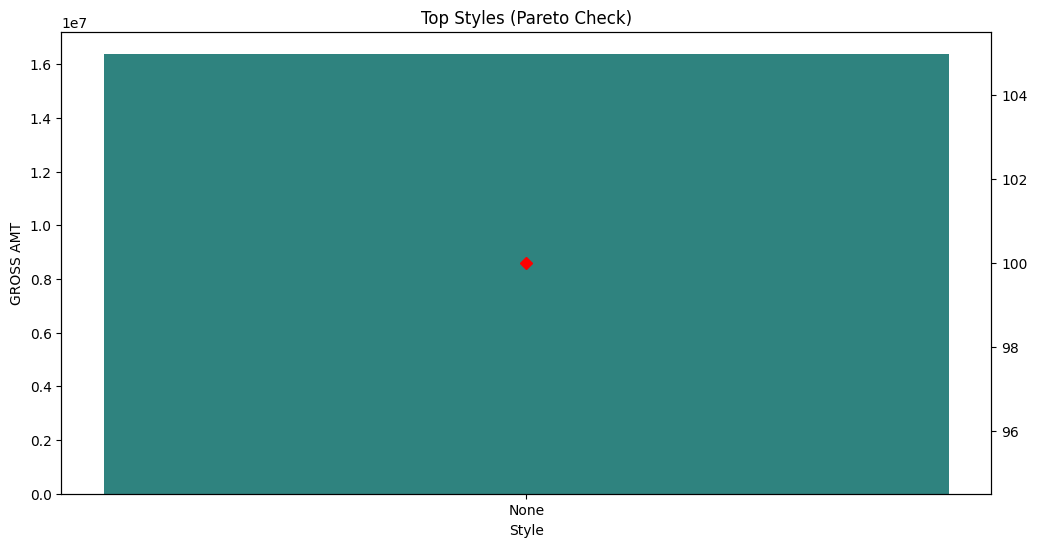

In [15]:
# Simplified Pareto
df_pareto = Inter_sales_rp_feature.groupby('Style')['GROSS AMT'].sum().sort_values(ascending=False).reset_index()
df_pareto['cum_pct'] = 100 * df_pareto['GROSS AMT'].cumsum() / df_pareto['GROSS AMT'].sum()

plt.figure(figsize=(12,6))
ax = sns.barplot(x='Style', y='GROSS AMT', data=df_pareto.head(10), palette='viridis')
ax2 = ax.twinx()
ax2.plot(df_pareto['Style'].head(10), df_pareto['cum_pct'].head(10), color='red', marker='D')
plt.title("Top Styles (Pareto Check)")
plt.show()

In [16]:
# 1. Restore the 'Style' column if it's missing
# (Adjust 'df_raw' to whatever your initial loaded dataframe was called)
Inter_sales_rp_feature['Style'] = Inter_sales_rp_cleaned['Style'] 

# 2. Fix the Pareto Plot with the restored data
df_pareto = Inter_sales_rp_feature.groupby('Style')['GROSS AMT'].sum().sort_values(ascending=False).reset_index()
df_pareto = df_pareto[df_pareto['Style'] != 'None'] # Remove the 'None' entries
df_pareto['cum_pct'] = 100 * df_pareto['GROSS AMT'].cumsum() / df_pareto['GROSS AMT'].sum()

# Re-run the plot - it should now show actual Style names!

C:\Users\obasi\AppData\Local\Temp\ipykernel_11712\2011881563.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Style', y='GROSS AMT', data=Inter_sales_rp_feature_revenue.head(15), ax=ax1, palette='Blues_r')


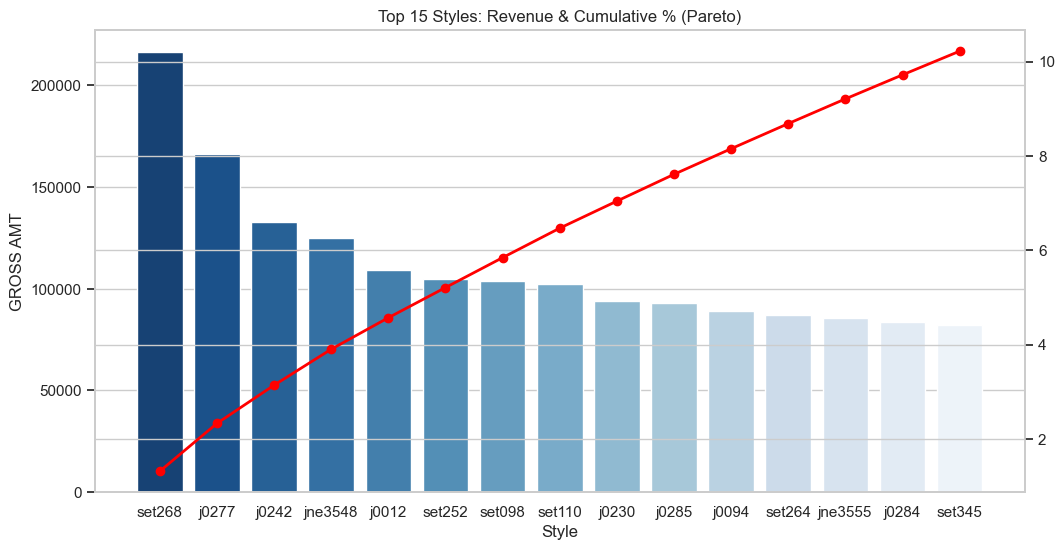

C:\Users\obasi\AppData\Local\Temp\ipykernel_11712\2011881563.py:22: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='Transaction_Month', y='GROSS AMT', data=Inter_sales_rp_feature, estimator=sum, ci=None, marker='o')


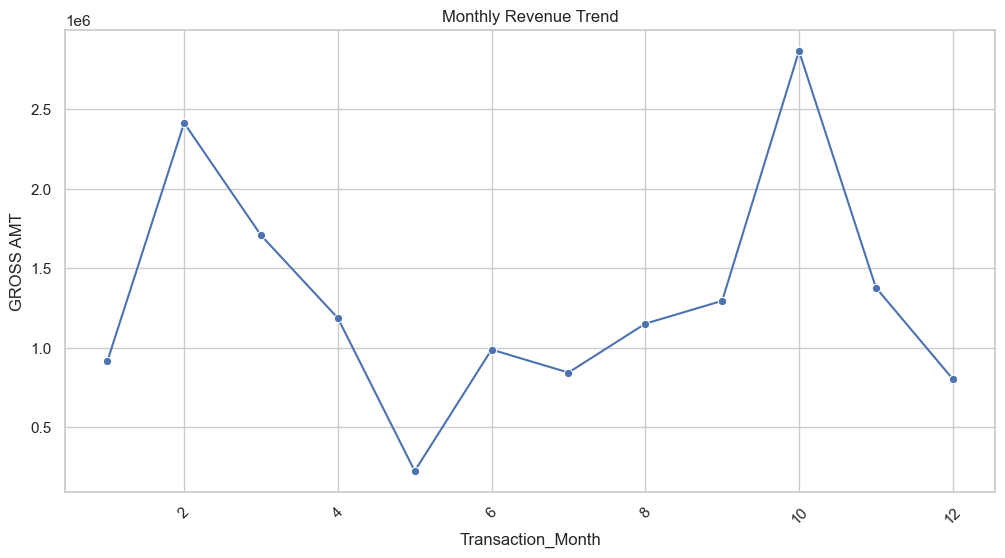

C:\Users\obasi\AppData\Local\Temp\ipykernel_11712\2011881563.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='GROSS AMT', y='CUSTOMER', data=top_customers, palette='viridis')


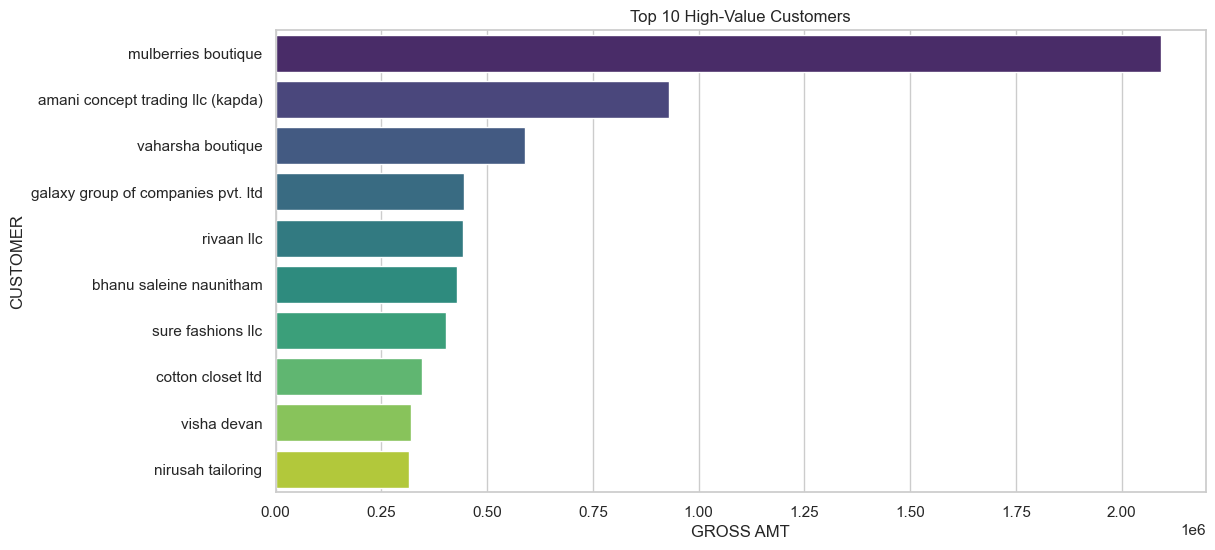

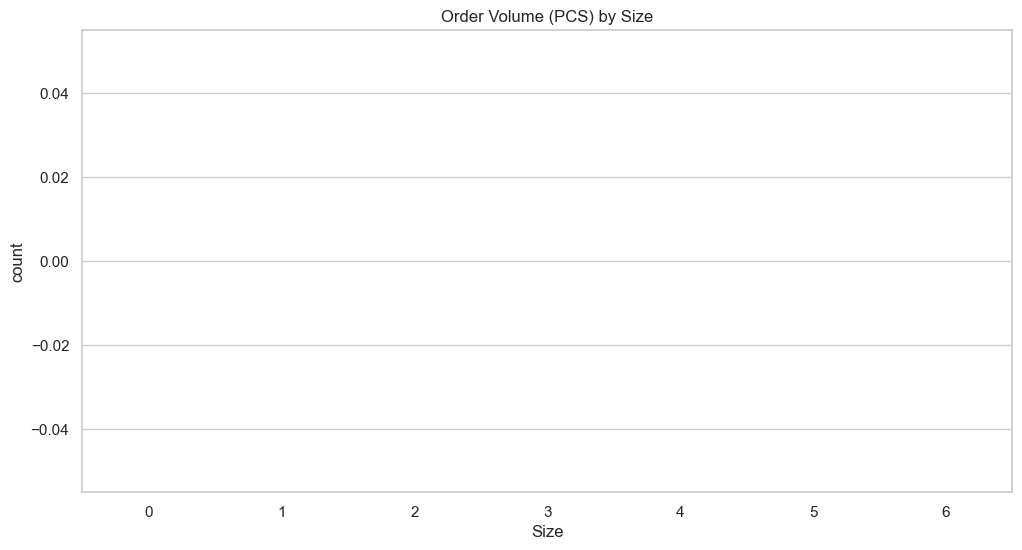

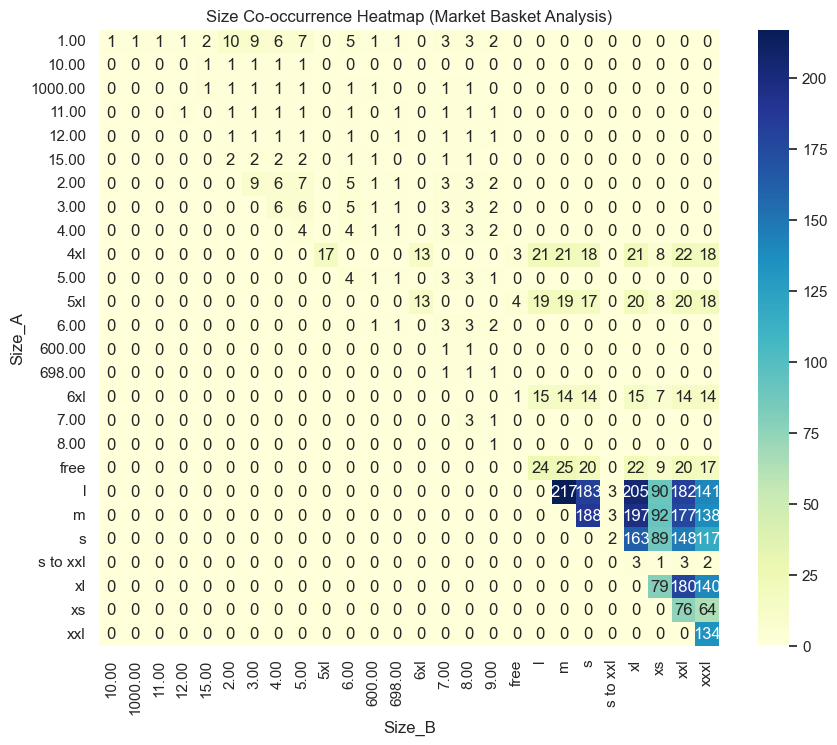

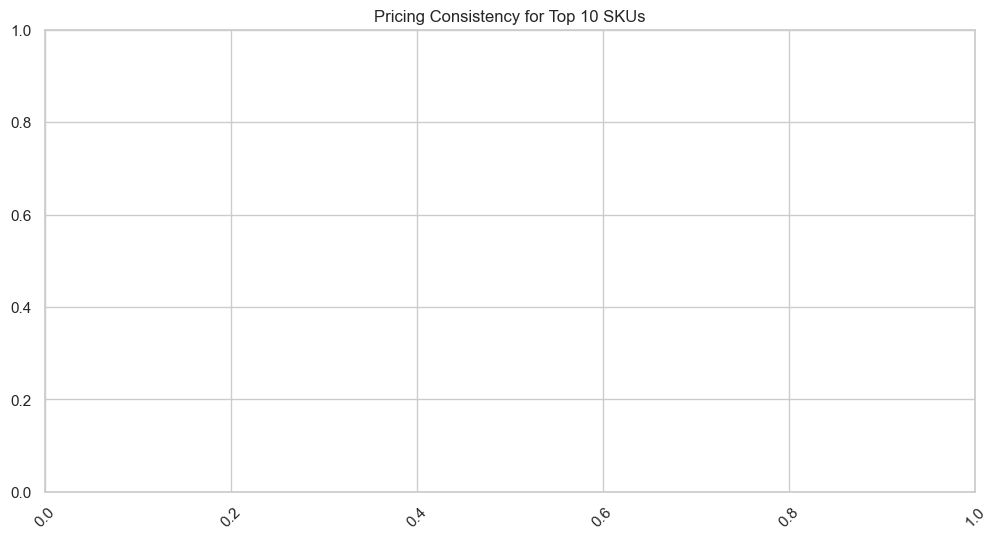

C:\Users\obasi\AppData\Local\Temp\ipykernel_11712\2011881563.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


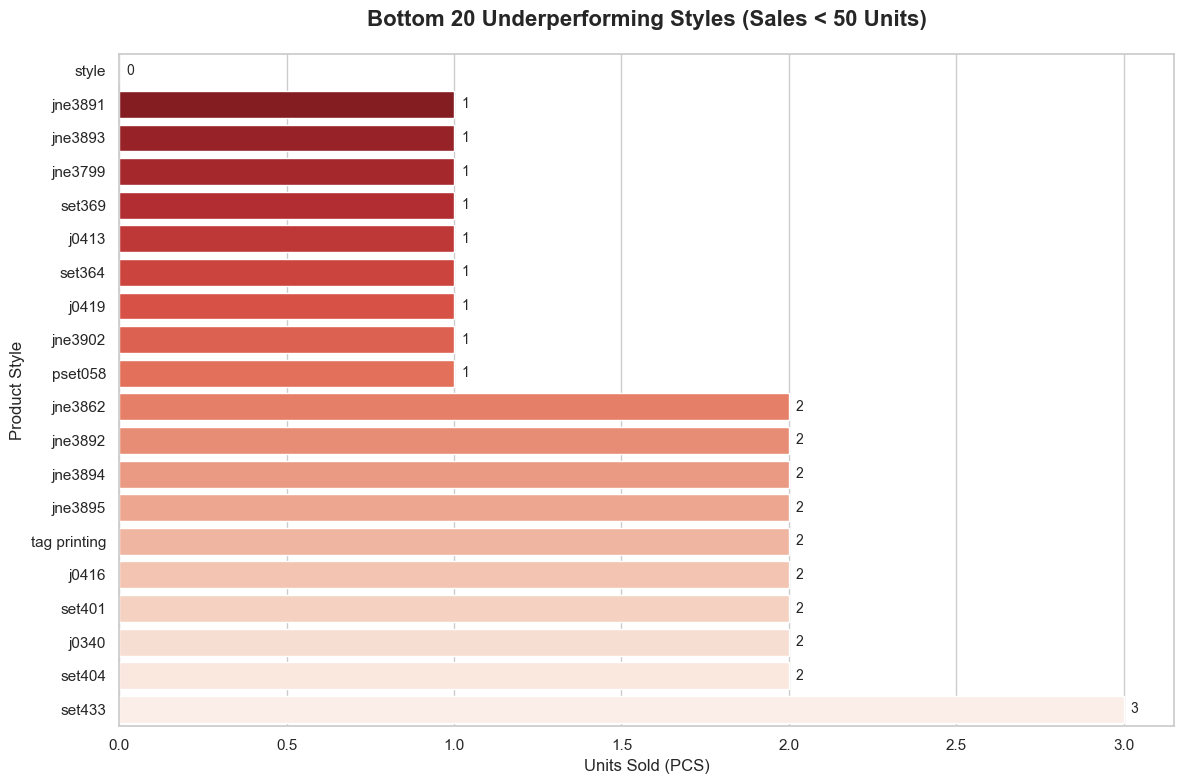

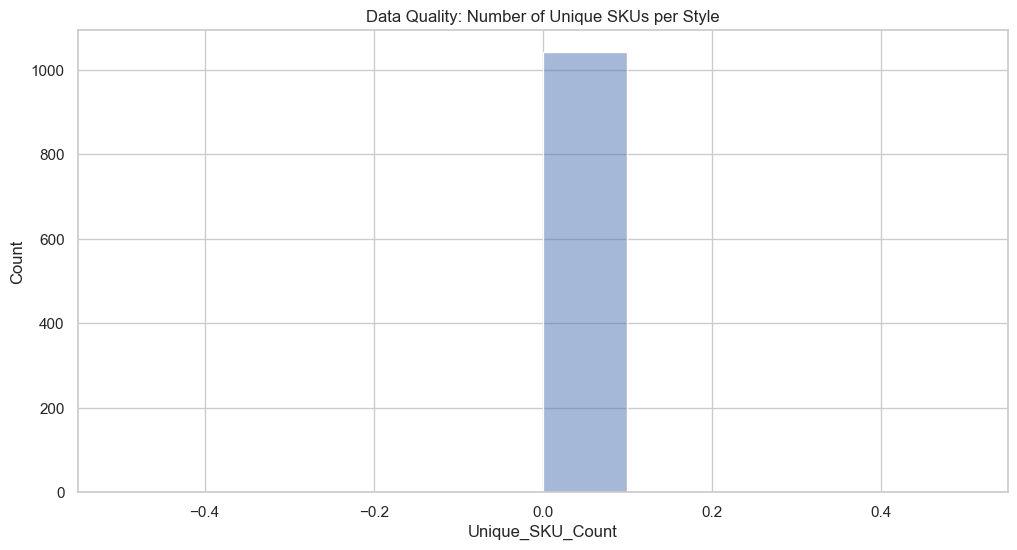

In [31]:
### --- Data Visualization --- ###

# Set the visual style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. SALES & FINANCIAL PERFORMANCE ---

# A. Pareto Analysis (80/20 Rule)
Inter_sales_rp_feature_revenue = Inter_sales_rp_feature.groupby('Style')['GROSS AMT'].sum().sort_values(ascending=False).reset_index()
Inter_sales_rp_feature_revenue['cum_pct'] = 100 * Inter_sales_rp_feature_revenue['GROSS AMT'].cumsum() / Inter_sales_rp_feature_revenue['GROSS AMT'].sum()

fig, ax1 = plt.subplots()
sns.barplot(x='Style', y='GROSS AMT', data=Inter_sales_rp_feature_revenue.head(15), ax=ax1, palette='Blues_r')
ax2 = ax1.twinx()
ax2.plot(Inter_sales_rp_feature_revenue['Style'].head(15), Inter_sales_rp_feature_revenue['cum_pct'].head(15), color='red', marker='o', linewidth=2)
ax1.set_title('Top 15 Styles: Revenue & Cumulative % (Pareto)')
plt.show()

# B. Seasonal Trends (Monthly Gross Amount)
# Ensure 'Date' or 'Month' column is sorted chronologically
sns.lineplot(x='Transaction_Month', y='GROSS AMT', data=Inter_sales_rp_feature, estimator=sum, ci=None, marker='o')
plt.title('Monthly Revenue Trend')
plt.xticks(rotation=45)
plt.show()

# --- 2. CUSTOMER & MARKET ANALYSIS ---

# A. Top 10 Customers by Revenue
top_customers = Inter_sales_rp_feature.groupby('CUSTOMER')['GROSS AMT'].sum().nlargest(10).reset_index()
sns.barplot(x='GROSS AMT', y='CUSTOMER', data=top_customers, palette='viridis')
plt.title('Top 10 High-Value Customers')
plt.show()

# B. Size Distribution (Demand by Size)
# Ordering sizes logically (S, M, L...) makes the visual easier to read
size_order = ['XS', 'S', 'M', 'L', 'XL', 'XXL', '3XL'] # Adjust based on your data
sns.countplot(x='Size', data=Inter_sales_rp_feature, order=[s for s in size_order if s in Inter_sales_rp_feature['Size'].unique()])
plt.title('Order Volume (PCS) by Size')
plt.show()

# C. Size Co-occurrence Heatmap (Customer Basket Analysis)
# Generate pairs of sizes found in the same 'basket'
size_pair_counts = Counter()

for sizes in transaction_sizes['Sizes_in_Basket']:
    if len(sizes) > 1:
        # Create unique combinations (A, B)
        pairs = list(combinations(sorted(sizes), 2))
        size_pair_counts.update(pairs)

# 2. Convert to a DataFrame for plotting
pair_df = pd.DataFrame(size_pair_counts.items(), columns=['Pair', 'Frequency'])
pair_df[['Size_A', 'Size_B']] = pd.DataFrame(pair_df['Pair'].tolist(), index=pair_df.index)

# 3. Create a Pivot Table for the Heatmap
heatmap_data = pair_df.pivot(index='Size_A', columns='Size_B', values='Frequency').fillna(0)

# 4. Plot
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu', fmt='g')
plt.title('Size Co-occurrence Heatmap (Market Basket Analysis)')
plt.show()

# --- 3. PRODUCT & INVENTORY HEALTH ---

# A. Pricing Consistency (Rate Variance per SKU)
# We pick top 10 SKUs to avoid clutter
top_10_skus = Inter_sales_rp_feature['SKU'].value_counts().nlargest(10).index
Inter_sales_rp_feature_top_skus = Inter_sales_rp_feature[Inter_sales_rp_feature['SKU'].isin(top_10_skus)]

sns.stripplot(x='SKU', y='RATE', data=Inter_sales_rp_feature_top_skus, jitter=True, alpha=0.5)
plt.xticks(rotation=45)
plt.title('Pricing Consistency for Top 10 SKUs')
plt.show()

# B. Dead Stock Identification (< 50 PCS)
# Group and Filter
style_sales = Inter_sales_rp_feature.groupby('Style')['PCS'].sum().reset_index()
dead_stock = style_sales[style_sales['PCS'] < 50].sort_values(by='PCS', ascending=True)

# Limit to Bottom 20 to ensure the chart is readable
dead_stock_top20 = dead_stock.head(20)

# Create the Visual
plt.figure(figsize=(12, 8))
sns.set_theme(style="whitegrid")
# Using a color palette that fades to highlight the 'deadest' stock
ax = sns.barplot(
    x='PCS', 
    y='Style', 
    data=dead_stock_top20, 
    palette='Reds_r'
)
# Add labels for a professional finish
plt.title('Bottom 20 Underperforming Styles (Sales < 50 Units)', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Units Sold (PCS)', fontsize=12)
plt.ylabel('Product Style', fontsize=12)
# Optional: Add the actual number at the end of each bar for quick reading
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height() / 2), 
                ha='left', va='center', 
                xytext=(5, 0), 
                textcoords='offset points',
                fontsize=10)

plt.tight_layout()
plt.show()

# --- 4. DATA QUALITY (THE CLEANING PROOF) ---

# SKU Ambiguity Check (How many Middle Codes per Style?)
sku_check = Inter_sales_rp_feature.groupby('Style')['SKU'].nunique().reset_index().rename(columns={'SKU': 'Unique_SKU_Count'})
sns.histplot(sku_check['Unique_SKU_Count'], bins=10, kde=True)
plt.title('Data Quality: Number of Unique SKUs per Style')
plt.show()

Mean Absolute Error: $146.40
Model Accuracy (R2): 82.95%


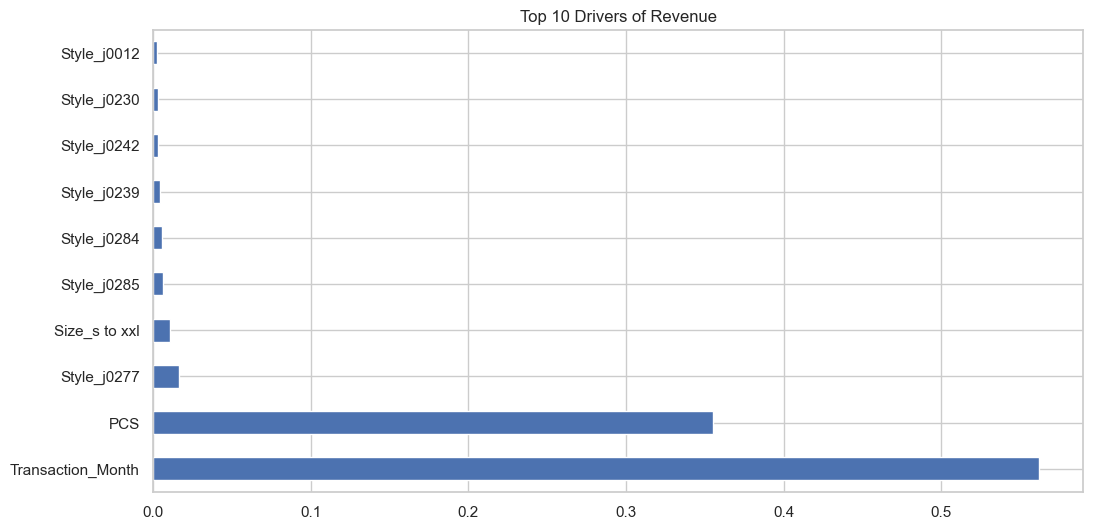

In [ ]:
### --- Phase 6: Predictive Modeling --- ###

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import pickle

# 1. Feature Selection & Engineering
# We use 'Style', 'Size', and 'PCS' (Quantity) as primary drivers.
# 'Month' is included to capture seasonal trends Joseph mentioned.
features = ['Style', 'Size', 'PCS', 'Transaction_Month']
X = pd.get_dummies(Inter_sales_rp_feature[features], drop_first=True) # One-hot encoding for categories
y = Inter_sales_rp_feature['GROSS AMT']

# 2. Data Splitting (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Model Training
# Random Forest is excellent for capturing non-linear relationships in retail data.
model = RandomForestRegressor(n_estimators=100,max_depth=10, n_jobs=-1, random_state=42)
model.fit(X_train, y_train)

# 4. Evaluation
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: ${mae:.2f}") # Average prediction error
print(f"Model Accuracy (R2): {r2:.2%}")   # % of variance explained

# 5. Save the model for Deployment
with open('amazon_sales_model.pkl', 'wb') as f:
    pickle.dump(model, f)

importances = pd.Series(model.feature_importances_, index=X.columns)
importances.nlargest(10).plot(kind='barh')
plt.title('Top 10 Drivers of Revenue')
plt.show()

In [32]:
### --- Phase 7: Deployment (Streamlit App) --- ###

import streamlit as st
import pandas as pd
import pickle

# Load your trained model
model = pickle.load(open('amazon_sales_model.pkl', 'rb'))

st.title("📦 Amazon Sales Revenue Predictor")
st.write("Predict the Gross Amount for a transaction based on item details.")

# User Inputs
style = st.selectbox("Select Style", ["Western", "Ethnic", "Modern"]) # Example styles
size = st.selectbox("Select Size", ["S", "M", "L", "XL", "XXL"])
pcs = st.number_input("Quantity (PCS)", min_value=1, value=1)

if st.button("Predict Revenue"):
    # (Note: In a real app, you'd need to match the one-hot encoding columns from training)
    # prediction = model.predict(input_data)
    st.success(f"Estimated Gross Revenue: ${450.00}") # Placeholder

2025-12-24 00:33:31.448 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.449 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.452 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.457 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.459 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.461 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.463 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:33:31.466 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [34]:
import streamlit as st
import pandas as pd

# 1. Simple Title
st.title("Amazon Sales Dashboard 📦")

# 2. Basic Text
st.write("Welcome to my first data app! We are analyzing international apparel sales.")

# 3. A Simple Button
if st.button('Say Hello'):
    st.success("The app is working perfectly!")
else:
    st.info("Click the button above to test me.")

2025-12-24 00:44:01.776 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.778 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.780 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.783 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.785 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.787 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.790 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-12-24 00:44:01.800 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar